In [ ]:
##############################################################
# BG-NBD ve Gamma-Gamma ile CLTV Prediction
##############################################################

# 1. Verinin Hazırlanması (Data Preperation)
# 2. BG-NBD Modeli ile Expected Number of Transaction
# 3. Gamma-Gamma Modeli ile Expected Average Profit
# 4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
# 6. Çalışmanın fonksiyonlaştırılması


# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
# pazarlama stratejileri belirlemek istiyor.

# Veri Seti Hikayesi

# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler

# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Veri Ön İşleme ve Verinin Hazırlanması***

In [ ]:
!pip install lifetimes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.9 MB/s eta 0:00:00


In [ ]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#kendisine girilen değişken için eşik değer belirleme
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01) # normalde 25 e 75 olarak belirlenir bu quantile değerleri bu projeye özeldir
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# dataframe den  değişken olarak alıcak ve üst sınır ve veya alt limite aykırı ise ona ata
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [ ]:
df_ = pd.read_excel("/content/drive/MyDrive/Kurs Materyalleri(CRM Analitiği)/datasets/online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")
df = df_.copy()
df.describe().T
df.head()
df.isnull().sum()

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541910.0000,9.5522,-80995.0000,1.0000,3.0000,10.0000,80995.0000,218.0810
InvoiceDate,541910,2011-07-04 13:35:22.342307584,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
Price,541910.0000,4.6111,-11062.0600,1.2500,2.0800,4.1300,38970.0000,96.7598
Customer ID,406830.0000,15287.6842,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000,1713.6031


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,406830.0000,12.0613,-80995.0000,2.0000,5.0000,12.0000,80995.0000,248.6931
InvoiceDate,406830,2011-07-10 16:31:30.127424512,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-31 11:48:00,2011-10-20 13:06:00,2011-12-09 12:50:00,NaN
Price,406830.0000,3.4605,0.0000,1.2500,1.9500,3.7500,38970.0000,69.3151
Customer ID,406830.0000,15287.6842,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000,1713.6031


In [ ]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397925.0000,13.0218,1.0000,2.0000,6.0000,12.0000,80995.0000,180.4200
InvoiceDate,397925,2011-07-10 23:44:09.817126400,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397925.0000,3.1162,0.0000,1.2500,1.9500,3.7500,8142.7500,22.0968
Customer ID,397925.0000,15294.3086,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1727


In [ ]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0000,12.9882,1.0000,2.0000,6.0000,12.0000,80995.0000,179.3316
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0000,3.1165,0.0010,1.2500,1.9500,3.7500,8142.7500,22.0979
Customer ID,397885.0000,15294.4169,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1444


In [ ]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")


In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0000,11.8308,1.0000,2.0000,6.0000,12.0000,298.5000,25.5231
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0000,2.8935,0.0010,1.2500,1.9500,3.7500,37.0600,3.2272
Customer ID,397885.0000,15294.4169,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1444


In [ ]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [ ]:
today_date = dt.datetime(2011, 12, 11)

# ***Lifetime Veri Yapısının Hazırlanması***

In [ ]:

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç


In [ ]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


In [ ]:
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.head()


,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [ ]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [ ]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,1892.1842,7706.2068,3.7500,303.3075,663.1000,1631.1075,266163.5250


In [ ]:

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df.describe().T



,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [ ]:

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [ ]:
cltv_df["recency"] = cltv_df["recency"] / 7

In [ ]:
cltv_df["T"] = cltv_df["T"] / 7

In [ ]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,28.4151,16.2667,0.0000,14.0000,29.5714,42.7143,53.2857
T,2845.0000,36.9692,14.7130,0.4286,27.4286,40.4286,51.2857,53.4286
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


In [ ]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100


# ***BG-NBD Modelinin Kurulması***

In [ ]:

bgf = BetaGeoFitter(penalizer_coef=0.001) # ceza katsayısı

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [ ]:

################################################################
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])


In [ ]:

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)


,0
Customer ID,
12748.0000,3.2495
14911.0000,3.1264
17841.0000,1.9402
13089.0000,1.5374
14606.0000,1.4639
15311.0000,1.4336
12971.0000,1.3569
14646.0000,1.2064
13408.0000,0.9862


In [ ]:

bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)


,0
Customer ID,
12748.0000,3.2495
14911.0000,3.1264
17841.0000,1.9402
13089.0000,1.5374
14606.0000,1.4639
15311.0000,1.4336
12971.0000,1.3569
14646.0000,1.2064
13408.0000,0.9862


In [ ]:

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])


In [ ]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223
...,...,...,...,...,...
18272.0000,34.8571,35.2857,6,513.0967,0.1721
18273.0000,36.4286,36.8571,3,68.0000,0.1043
18282.0000,16.8571,18.1429,2,89.0250,0.1357


In [ ]:
 #1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

In [ ]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])


In [ ]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862
...,...,...,...,...,...,...
18272.0000,34.8571,35.2857,6,513.0967,0.1721,0.6856
18273.0000,36.4286,36.8571,3,68.0000,0.1043,0.4157
18282.0000,16.8571,18.1429,2,89.0250,0.1357,0.5392


In [ ]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1776.8934732202868

In [ ]:
#Tahmin sonuçlarının değerlendirmesi

<Figure size 1000x600 with 0 Axes>

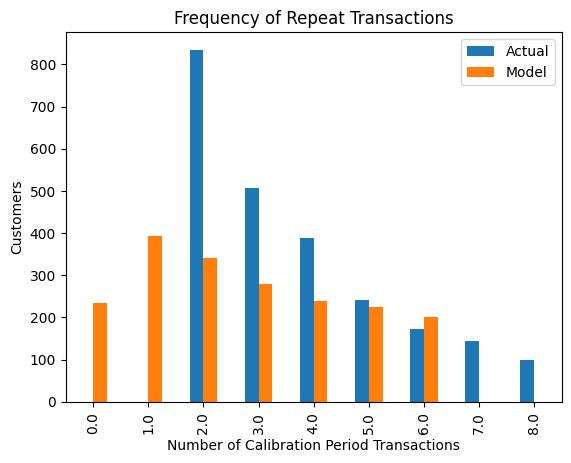

In [ ]:
plt.figure(figsize=(10, 6))
plot_period_transactions(bgf)
plt.show()

# ***Gamma-Gamma Modelinin Kurulması***

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [ ]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [ ]:

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)


,0
Customer ID,
12347.0000,631.9123
12348.0000,463.7460
12352.0000,224.8868
12356.0000,995.9989
12358.0000,631.9022
12359.0000,1435.0385
12360.0000,933.7905
12362.0000,532.2318
12363.0000,304.2643


In [ ]:

ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)


,0
Customer ID,
12415.0000,5772.1782
12590.0000,5029.4196
12435.0000,4288.9440
12409.0000,3918.8128
14088.0000,3917.1297
18102.0000,3870.9969
12753.0000,3678.5783
14646.0000,3654.8148
15749.0000,3216.0523


In [ ]:

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])


In [ ]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)


,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0460,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0379,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,3216.0523


# ***BG-NBD ve GG modeli ile CLTV'nin hesaplanması***

In [ ]:
 #4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
##############################################################




,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,1280.2183,12966.1347


In [ ]:

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)


In [ ]:
cltv.head()

,clv
Customer ID,
12347.0000,1128.4477
12348.0000,538.8089
12352.0000,517.5000
12356.0000,1083.0903
12358.0000,966.6727


In [ ]:
cltv = cltv.reset_index()

In [ ]:
cltv.head()

,Customer ID,clv
0,12347.0000,1128.4477
1,12348.0000,538.8089
2,12352.0000,517.5000
3,12356.0000,1083.0903
4,12358.0000,966.6727


In [ ]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,1280.2183,12966.1347


In [ ]:

bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [ ]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,expected_purc_3_month,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148,14.3340,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969,11.5112,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,3196.4361,8.5526,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782,4.5080,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,692.3264,37.1641,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,2874.1987,8.8830,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,2110.7542,10.4298,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,2950.5801,6.0476,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,2223.8850,5.6801,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,1280.2183,9.5186,12966.1347


bg / nbd recency değeri arttıkça müşteri satın alma olasılığı artar

# ***CLTV'ye Göre Segmentlerin Oluşturulması***

In [ ]:
cltv_final

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,expected_purc_3_month,clv
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,631.9123,1.6784,1128.4477
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,463.7460,1.0920,538.8089
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,224.8868,2.1631,517.5000
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,995.9989,1.0222,1083.0903
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,631.9022,1.4388,966.6727
...,...,...,...,...,...,...,...,...,...,...
2840,18272.0000,34.8571,35.2857,6,513.0967,0.1721,0.6856,529.0185,2.0369,1146.2057
2841,18273.0000,36.4286,36.8571,3,68.0000,0.1043,0.4157,73.4942,1.2352,96.5648
2842,18282.0000,16.8571,18.1429,2,89.0250,0.1357,0.5392,99.5249,1.5934,168.5946
2843,18283.0000,47.5714,48.2857,16,130.9300,0.3017,1.2034,132.6012,3.5831,505.5117


In [ ]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,expected_purc_3_month,clv,segment
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,3654.8148,14.3340,55741.0845,A
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,3870.9969,11.5112,47412.5801,A
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,3196.4361,8.5526,29061.6614,A
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,5772.1782,4.5080,27685.1000,A
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,692.3264,37.1641,27377.4115,A
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,2874.1987,8.8830,27166.0643,A
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,2110.7542,10.4298,23424.4032,A
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,2950.5801,6.0476,18986.6123,A
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,2223.8850,5.6801,13440.4131,A
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,1280.2183,9.5186,12966.1347,A


In [ ]:

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})



Customer ID                     recency                        T                  frequency             monetary                   expected_purc_1_week                expected_purc_1_month                expected_average_profit                   expected_purc_3_month                       clv                   
               mean           sum count    mean        sum count    mean        sum count      mean   sum count     mean         sum count                 mean      sum count                  mean      sum count                    mean         sum count                  mean       sum count      mean          sum count
segment                                                                                                                                                                                                                                                                                                                         
D        15558.4761 11077635.0000   712 22.0738 15716.5714   712 40.4649 28811.0000   712    3.0646  2182   712 183.9631 130981.7123   712               0.0711  50.5898   712                0.2830 201.4774   712                199.4377 141999.6650   712                0.8400  598.0905   712  143.2970  102027.4901   712
C        15309.6343 10885150.0000   711 30.6697 21806.1429   711 38.1111 27097.0000   711    4.0956  2912   711 271.6948 193174.9847   711               0.1206  85.7309   711                0.4802 341.3936   711                289.9856 206179.7461   711                1.4251 1013.2176   711  380.7919  270743.0065   711
B        15352.8186 10915854.0000   711 29.5148 20985.0000   711 34.8117 24751.1429   711    5.4416  3869   711 373.4425 265517.6312   711               0.1625 115.5066   711                0.6465 459.6926   711                393.8944 280058.9431   711                1.9165 1362.6595   711  688.2650  489356.3925   711
A        14947.3586 10627572.0000   711 31.4109 22333.1429   711 34.4840 24518.1429   711   11.3586  8076   711 659.8586 469159.4581   711               0.2736 194.4993   711                1.0891 774.3298   711                685.8998 487674.7239   711                3.2309 2297.1448   711 2222.3600 1580097.9284   711

# ***Functionalization***

In [57]:
def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final








In [58]:
df = df_.copy()

cltv_final2 = create_cltv_p(df)

cltv_final2.to_csv("cltv_prediction.csv")